<a href="https://colab.research.google.com/github/r4dtwhle/final_project_tsdw/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("SPOTIFY SONGS - DATA ANALYSIS & MODELING")
print("="*70)

github_url = 'https://raw.githubusercontent.com/r4dtwhle/final_project_tsdw/main/data/processed/cleaned_spotify_songs.csv'

print(f"\nLoading data from GitHub...")
try:
    df = pd.read_csv(github_url)
    print(f"Success! Loaded: {df.shape[0]} rows x {df.shape[1]} columns")
except Exception as e:
    print(f"Error: {e}")
    df = pd.read_csv('cleaned_spotify_songs.csv')

SPOTIFY SONGS - DATA ANALYSIS & MODELING

Loading data from GitHub...
Success! Loaded: 30894 rows x 33 columns


MODEL 1: PREDIKSI LAGU HIT (Popularity Prediction)

Class Distribution:
Hit Songs: 15496 (50.2%)
Non-Hit Songs: 15398 (49.8%)

Feature Scaling...
Train-Test Split (80-20)...
Train set: 24715 samples
Test set: 6179 samples

Training Models...
Random Forest...
Gradient Boosting...

Model Performance:
Random Forest - R2: 0.2439 | RMSE: 21.86
Gradient Boosting - R2: 0.1342 | RMSE: 23.39

Top 10 Important Features for Hit Songs:
loudness........................... 0.0981
duration_min....................... 0.0979
instrumentalness................... 0.0972
tempo.............................. 0.0912
energy............................. 0.0833
speechiness........................ 0.0774
liveness........................... 0.0718
acousticness....................... 0.0690
danceability....................... 0.0635
mood_index......................... 0.0564

Creating Visualizations for Model 1...
Saved: 01_model_popularity_prediction.png


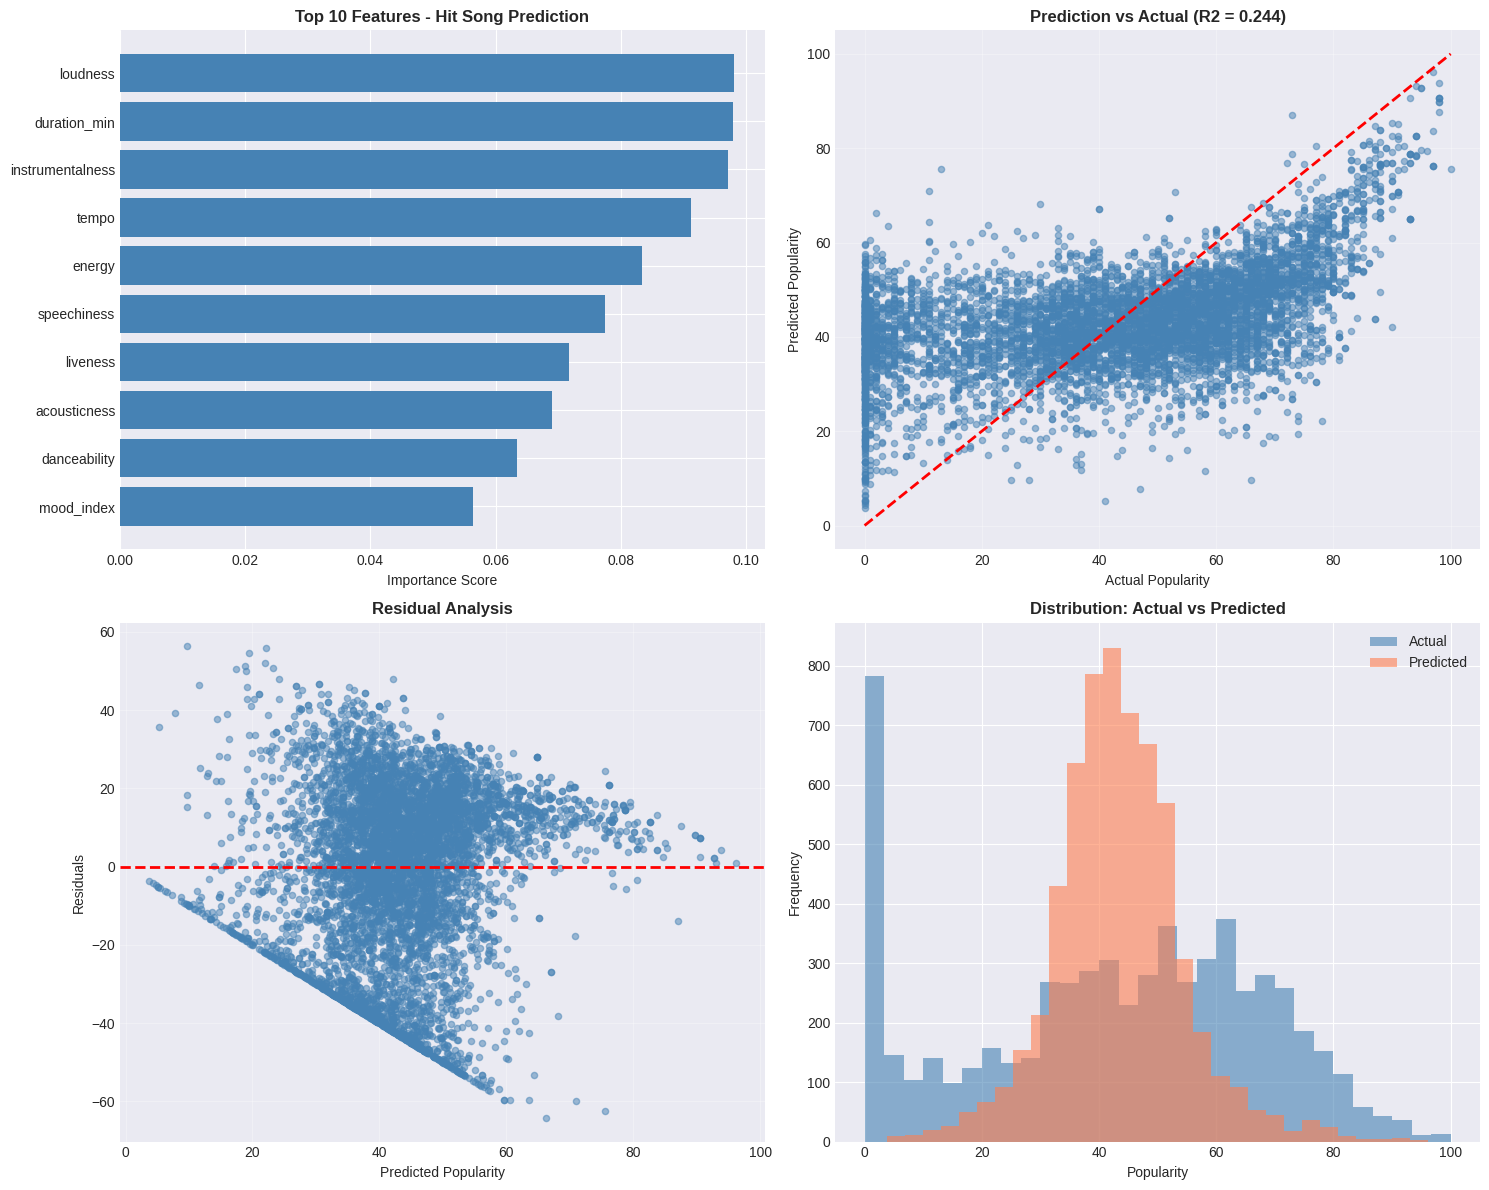

In [2]:
print("MODEL 1: PREDIKSI LAGU HIT (Popularity Prediction)")
df['is_hit'] = (df['track_popularity'] >= df['track_popularity'].median()).astype(int)
hit_count = df['is_hit'].sum()
non_hit_count = len(df) - hit_count

print(f"\nClass Distribution:")
print(f"Hit Songs: {hit_count} ({hit_count/len(df)*100:.1f}%)")
print(f"Non-Hit Songs: {non_hit_count} ({non_hit_count/len(df)*100:.1f}%)")

feature_cols = ['danceability', 'energy', 'loudness', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence',
                'tempo', 'duration_min', 'key', 'mode',
                'energy_danceability', 'mood_index', 'upbeat_score']

X = df[feature_cols].copy()
y = df['track_popularity'].copy()

print("\nFeature Scaling...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("Train-Test Split (80-20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nTraining Models...")
print("Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15,
                                random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                    max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
gb_r2 = r2_score(y_test, gb_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))

print("\nModel Performance:")
print(f"Random Forest - R2: {rf_r2:.4f} | RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosting - R2: {gb_r2:.4f} | RMSE: {gb_rmse:.2f}")

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features for Hit Songs:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:.<35} {row['importance']:.4f}")

print("\nCreating Visualizations for Model 1...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].barh(feature_importance['feature'].head(10),
               feature_importance['importance'].head(10),
               color='steelblue')
axes[0, 0].set_title('Top 10 Features - Hit Song Prediction',
                    fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Importance Score')

axes[0, 1].scatter(y_test, rf_pred, alpha=0.5, s=20, color='steelblue')
axes[0, 1].plot([y_test.min(), y_test.max()],
               [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Popularity')
axes[0, 1].set_ylabel('Predicted Popularity')
axes[0, 1].set_title(f'Prediction vs Actual (R2 = {rf_r2:.3f})',
                    fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

residuals = y_test - rf_pred
axes[1, 0].scatter(rf_pred, residuals, alpha=0.5, s=20, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Popularity')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Analysis', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(y_test, bins=30, alpha=0.6, label='Actual', color='steelblue')
axes[1, 1].hist(rf_pred, bins=30, alpha=0.6, label='Predicted', color='coral')
axes[1, 1].set_xlabel('Popularity')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution: Actual vs Predicted',
                    fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('01_model_popularity_prediction.png', dpi=300, bbox_inches='tight')
print("Saved: 01_model_popularity_prediction.png")
plt.show()